[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rinivarg/ReproRehab2024-Pod3/blob/main/Materials/Week%203/Week%203%20-%20Codebook.ipynb)

# Week 5 Statistics
This notebook covers demographics tables, group comparisons, linear models, mixed models, and model comparison techniques.

## Clear Entire Workspace

In [11]:
# Clear the entire workspace
rm(list = ls())
# gc()

## Load Libraries

In [109]:
ReqdLibs = c("IRdisplay","ggplot2","readxl","ggthemes","nlme","gtsummary","huxtable","officer","dplyr","car","emmeans","broom")
invisible(lapply(ReqdLibs, library, character.only = TRUE))

## Theme Defaults

In [40]:
thm = theme(
          strip.text.x=element_text(size=20,face="bold"),
          strip.text.y=element_text(size=20,face="bold"),
          legend.text=element_text(size=16,face="bold"),
          legend.position = "top",
          legend.title=element_text(size=16,face="bold"),
          title =element_text(size=14, face='bold'),
          text = element_text(colour = "black",size=18), 
          plot.title = element_text(colour = "black",size = 22, face = "bold"),
          axis.ticks.length = unit(0.3,"cm"),
          axis.line = element_line(colour = "black",linewidth=0.85),
          axis.ticks = element_line(colour = "black",size=0.85),
          axis.text = element_text(colour = "black",size=24),
          axis.title=element_text(size=25))

## 4. Read Data

In [45]:
# Read in demographics data
demo <- read_excel("SubjectInfo.xlsx")

# Read in task data
data.task <- read.csv("raw.data.all.csv")

# Display structure of demo data
# str(demo)
head(demo)
head(data.task)

Subject No,Age,Reported Weight (kg),Reported Length (cm),Gender,Level Slow,Level Walk,Weight from force plates(kg)
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Sub1,26,86,185,M,885.5529,891.5307,90.57511
Sub2,28,77,178,F,767.7686,760.2377,77.88004
Sub3,21,52,170,M,530.6408,558.2018,55.49656
Sub4,25,73,168,M,NA,NA,NA
Sub5,34,86,173,M,878.6303,898.5188,90.57845
Sub6,19,54,160,F,553.4936,558.2845,56.66555


,X,t,Rf,VT,VE,VO2,Sub,trial
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,2,18.51852,0.7548531,13.97876,408.6987,Sub1,rest
2,2,5,20.97902,0.5538989,11.62026,304.7868,Sub1,rest
3,3,8,18.23708,0.7058896,12.87337,347.7043,Sub1,rest
4,4,10,25.53191,0.7823950,19.97604,614.8135,Sub1,rest
5,5,13,21.97802,0.4957548,10.89571,253.6431,Sub1,rest
6,6,16,18.92744,0.7874953,14.90527,437.0967,Sub1,rest


## 5. Demographics Table and Group Comparisons

Reference: https://www.danieldsjoberg.com/gtsummary/articles/tbl_summary.html

In [111]:
# Clean demographics data
demo.clean <- demo[, c(-1)]
demo.clean$Age <- as.numeric(demo.clean$Age)

# Create basic summary table
tb <- tbl_summary(demo.clean,
            statistic = list( 
                 all_continuous() ~ "{mean} ({sd})", 
                 all_categorical() ~ "{n} ({p}%)" 
               ),
            type = list(Age ~ "continuous", `Reported Length (cm)` ~ "continuous"),
               digits = all_continuous() ~ 2, # Two decimal points for continuous
               missing = "ifany") %>%
  bold_labels()

tb %>% 
  as_gt() %>%
  gt::gtsave("summary_table.html")
browseURL("summary_table.html")

In [113]:
# Create summary table grouped by gender
tb.group <- tbl_summary(demo.clean,
               by = Gender,
            statistic = list( 
                 all_continuous() ~ "{mean} ({sd})", 
                 all_categorical() ~ "{n} ({p}%)" 
               ),
            type = list(Age ~ "continuous", `Reported Length (cm)` ~ "continuous"),
               digits = all_continuous() ~ 2,
               missing = "ifany") %>%
  # add_p() %>%
  bold_labels() 

tb.group %>% 
  as_gt() %>%
  gtsave("summary_table_comp.html")
browseURL("summary_table_comp.html")

## 6. Linear Models

In [145]:
# Merge task data with demographics
data.all <- merge(data.task, demo, by.x = "Sub", by.y = "Subject No")

# Aggregate all data by subject age and gender
data.agg <- aggregate(VO2 ~ Age + Gender + Sub, data.all, mean)

# Check mean VO2 by gender
aggregate(VO2 ~ Gender, data.all, mean)

Gender,VO2
<chr>,<dbl>
F,984.5398
M,1188.7765


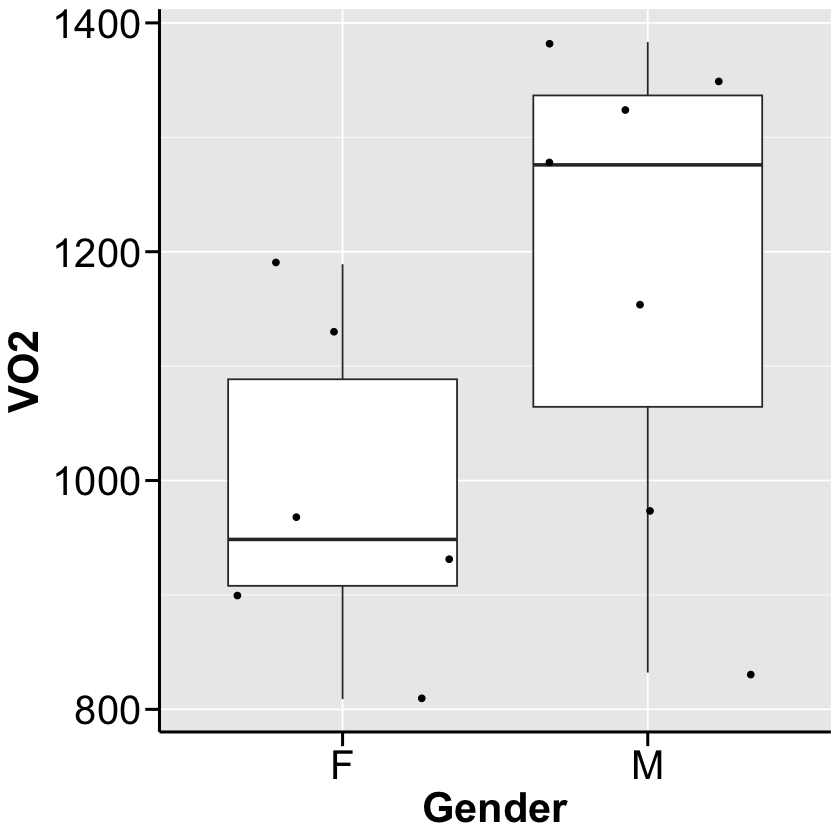

In [146]:
# Visualize VO2 by gender
ggplot(data.agg, aes(x = Gender, y = VO2)) +
  geom_boxplot() +
  geom_jitter() + thm

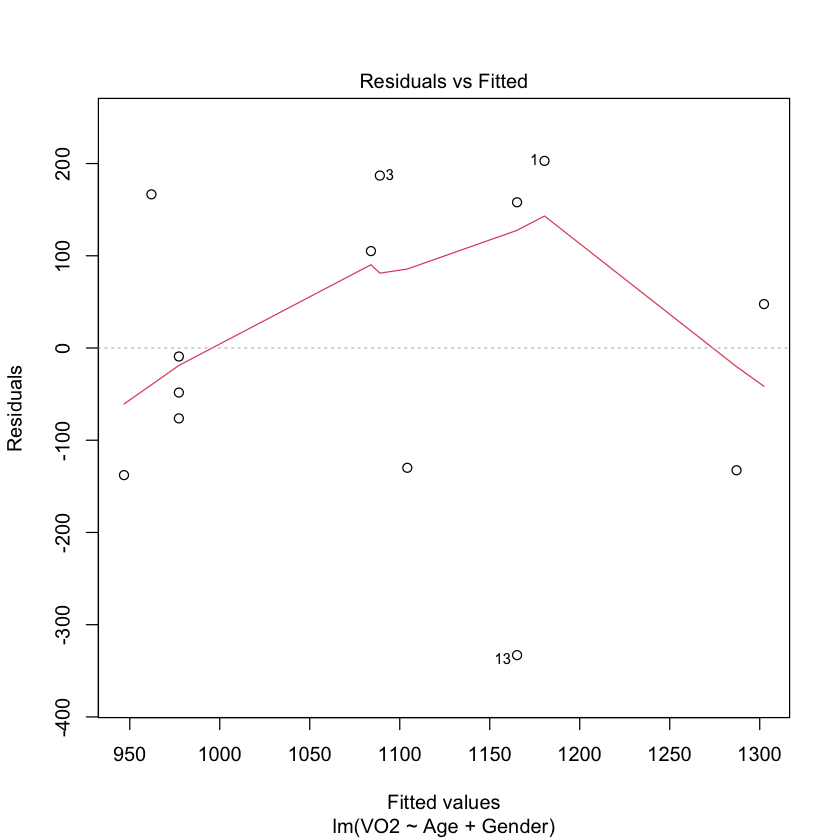

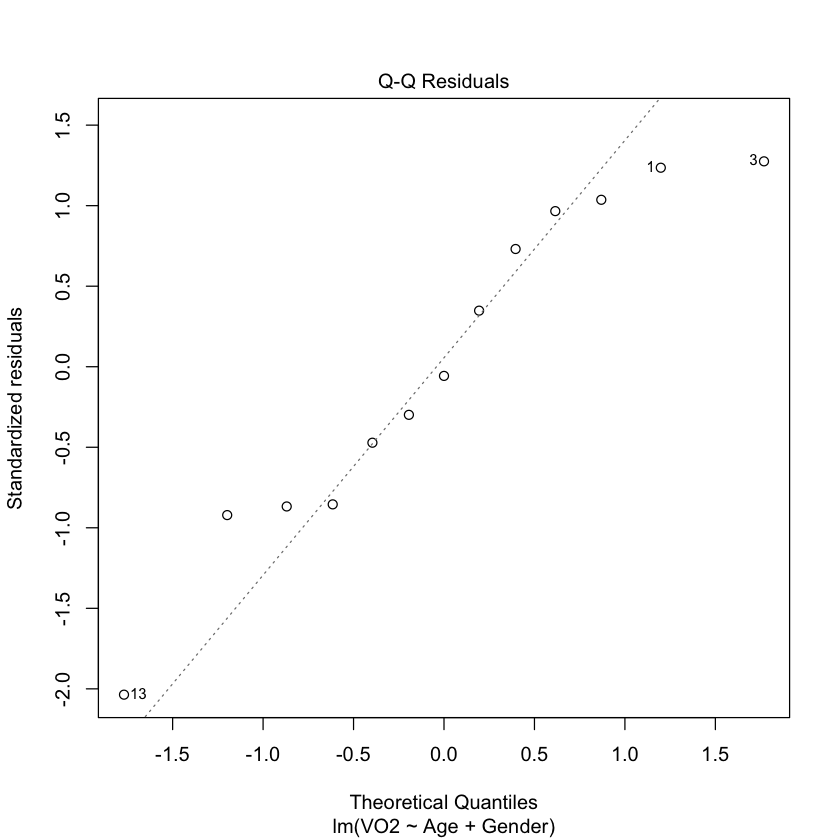

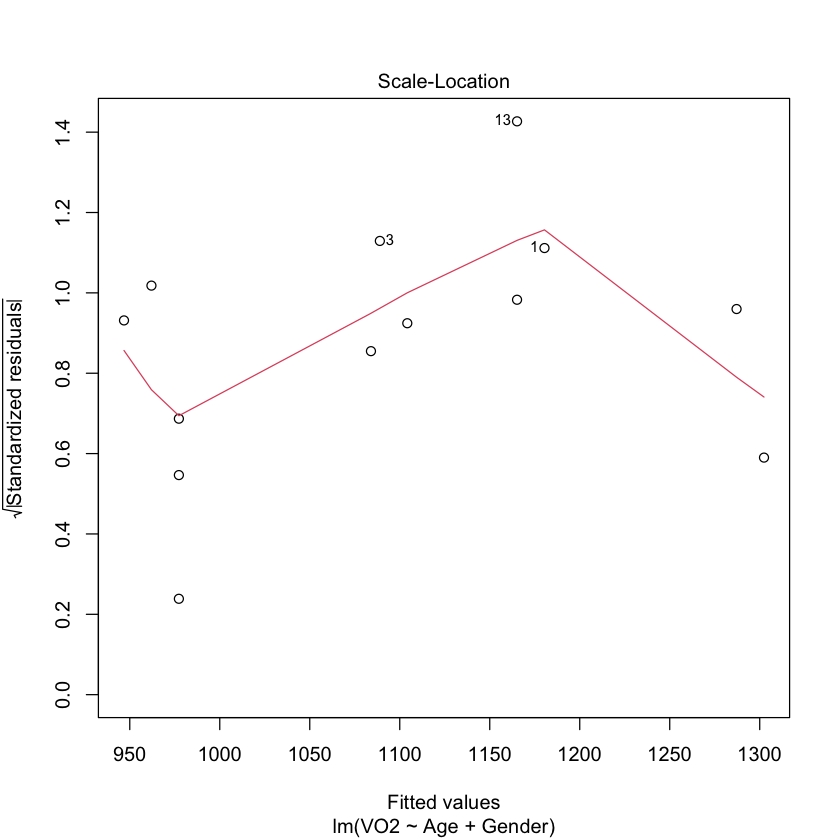

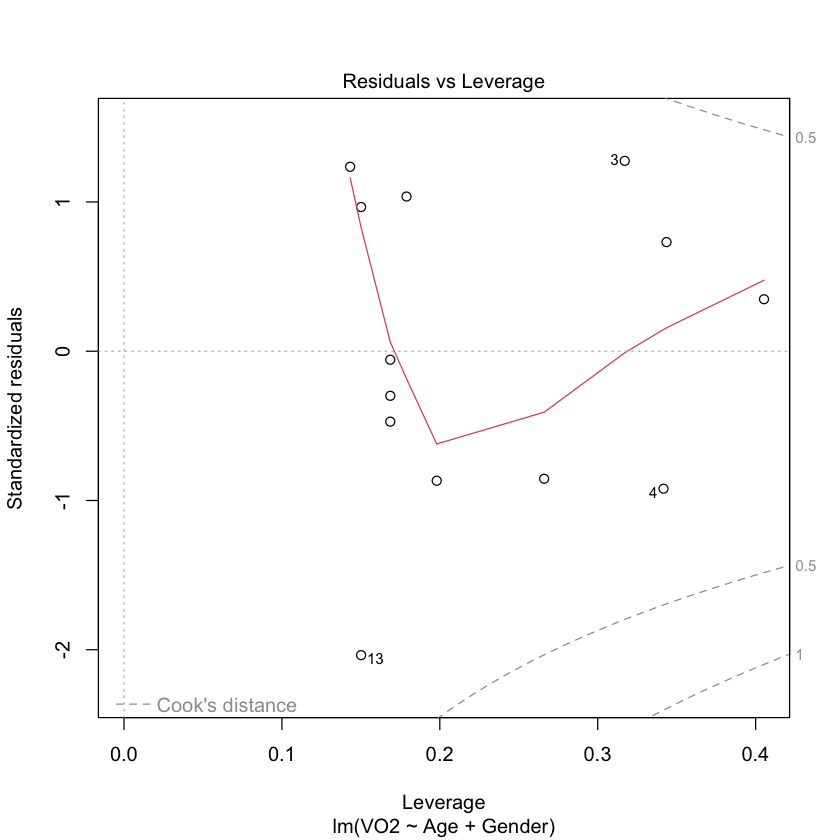

In [147]:
# Prepare data for linear modeling
data.agg$Gender <- factor(data.agg$Gender, levels = c("F", "M"))

# Run first linear model with lm()
fit <- lm(VO2 ~ Age + Gender, data.agg)

# Check model assumptions
plot(fit)

In [118]:
# Check for collinearity and outliers
vif(fit) # Check for collinearity
cooks.distance(fit) # Check for outliers

# Model summary and confidence intervals
tidy(fit)
confint(fit)


Age   Gender 
1.303977 1.303977

1           2           3           4           5           6 
0.085061356 0.078027542 0.251698070 0.146790987 0.015047893 0.093197866 
          7           8           9          10          11          12 
0.088249850 0.054965527 0.027529781 0.061953889 0.006031350 0.000219273 
         13 
0.244149178

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),657.13470,265.33871,2.476588,0.03273352
Age,15.24508,11.78134,1.294002,0.22475051
GenderM,126.90727,112.70981,1.125965,0.28647654


,2.5 %,97.5 %
(Intercept),65.92321,1248.34618
Age,-11.00538,41.49554
GenderM,-124.22584,378.04038


In [122]:
# Create formatted regression table
gtsummary::tbl_regression(fit,
               show_single_row = "Gender",
               label = list(Gender = "Gender(Male)"),
               intercept = T)


ERROR: [1m[33mError[39m in `check_pkg_installed()`:[22m
[1m[22m[33m![39m The package "broom.helpers" (>= 1.20.0) is required.


## 7. Mixed Models

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


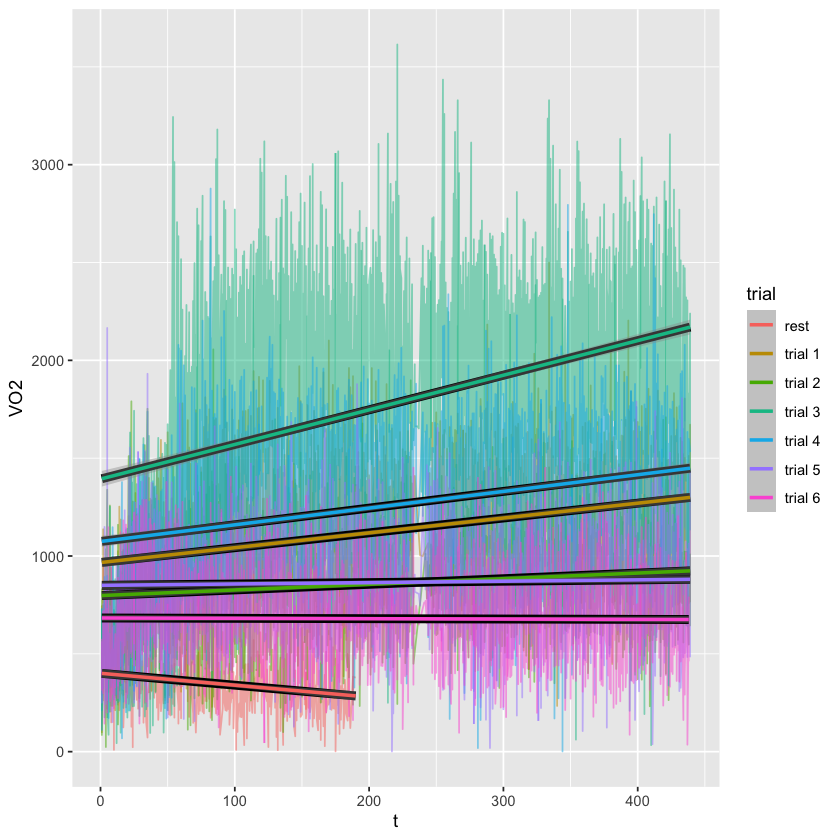

In [132]:
# Filter data (remove t >= 440)
data.all <- data.all[data.all$t < 440, ]

# Visualize VO2 over time by trial
ggplot(data.all, aes(x = t, y = VO2, color = trial, group = trial)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm', color = "black", se = F, size = 2.5) +
  geom_smooth(method = 'lm')

In [133]:
# Create Level variable
data.all$Level <- "Level"
data.all$Level[data.all$trial == "trial 3" | data.all$trial == "trial 4"] <- "Uphill"
data.all$Level[data.all$trial == "trial 5" | data.all$trial == "trial 6"] <- "Downhill"

# Create Speed variable
data.all$Speed <- "Fast"
data.all$Speed[data.all$trial == "trial 2" | data.all$trial == "trial 4" | data.all$trial == "trial 6"] <- "Slow"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


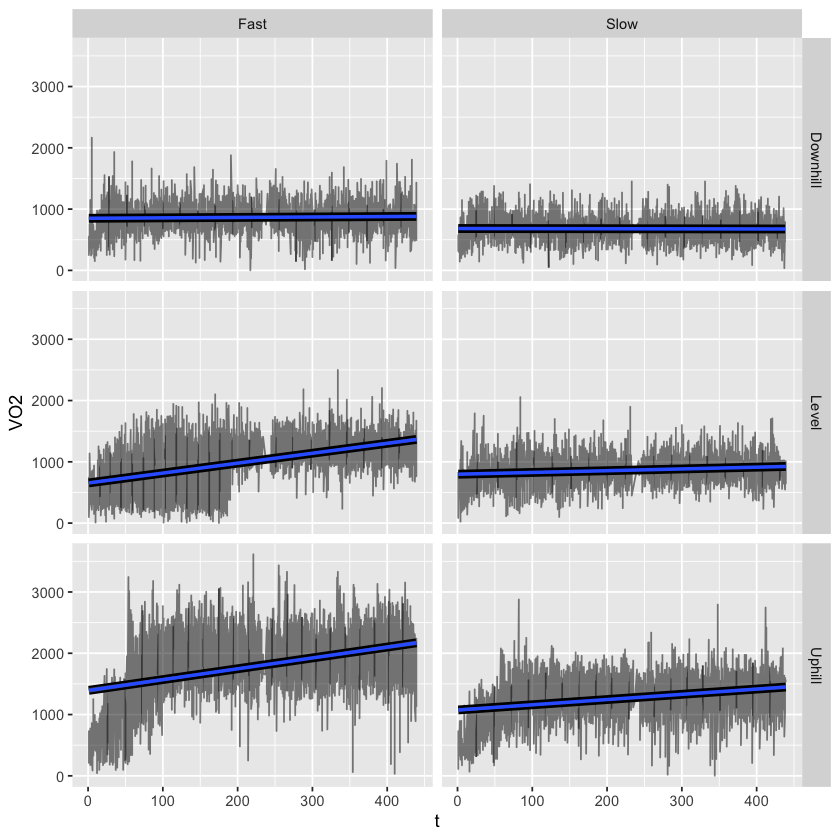

In [134]:
# Visualize by Level and Speed
ggplot(data.all, aes(x = t, y = VO2)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm', color = "black", se = F, size = 2.5) +
  geom_smooth(method = 'lm') +
  facet_grid(Level ~ Speed)

`geom_smooth()` using formula = 'y ~ x'


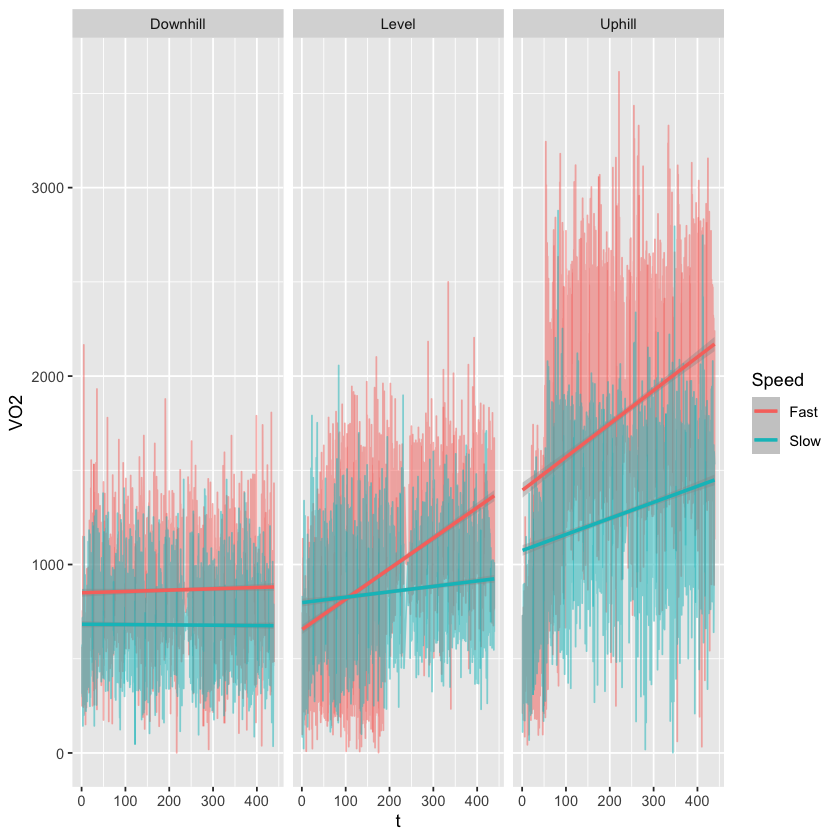

In [135]:
# Alternative visualization
ggplot(data.all, aes(x = t, y = VO2, color = Speed)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm') +
  facet_wrap(~Level)

In [136]:
# Fit mixed effects model
fit.lme <- lme(VO2 ~ t*Speed + t*Level + Age + Gender,
            random = ~1|Sub,
            method = "ML",
            data.all)

# Model diagnostics
Anova(fit.lme)
vif(fit.lme)
summary(fit.lme)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
t,1838.460981,1,0.000000e+00
Speed,3149.980017,1,0.000000e+00
Level,16290.699186,2,0.000000e+00
Age,1.898113,1,1.682897e-01
Gender,1.096563,1,2.950216e-01
t:Speed,435.655061,1,9.551752e-97
t:Level,760.820966,2,6.163486e-166


,GVIF,Df,GVIF^(1/(2*Df))
t,4.266512,1,2.065554
Speed,3.923103,1,1.980682
Level,15.218707,2,1.975124
Age,1.304089,1,1.141967
Gender,1.304072,1,1.141960
t:Speed,4.853385,1,2.203040
t:Level,23.596949,2,2.204012


Linear mixed-effects model fit by maximum likelihood
  Data: data.all 
       AIC      BIC    logLik
  209435.1 209526.2 -104705.6

Random effects:
 Formula: ~1 | Sub
        (Intercept) Residual
StdDev:    154.0267 305.8998

Fixed effects:  VO2 ~ t * Speed + t * Level + Age + Gender 
                  Value Std.Error    DF   t-value p-value
(Intercept)    433.3566 231.10377 14635   1.87516  0.0608
t                0.4348   0.04093 14635  10.62256  0.0000
SpeedSlow     -105.0763  10.05381 14635 -10.45140  0.0000
LevelLevel     -70.9294  12.24631 14635  -5.79190  0.0000
LevelUphill    458.4397  12.63535 14635  36.28232  0.0000
Age             14.1198  10.25215    10   1.37725  0.1985
GenderM        102.6570  98.06637    10   1.04681  0.3198
t:SpeedSlow     -0.8324   0.03990 14635 -20.86523  0.0000
t:LevelLevel     1.0083   0.04919 14635  20.49767  0.0000
t:LevelUphill    1.3102   0.04942 14635  26.50968  0.0000
 Correlation: 
              (Intr) t      SpdSlw LvlLvl LvlUph Age    Gendr

### Marginal Means and Trend Analysis

In [ ]:
# Calculate marginal (adjusted) means for level and speed
# This gives us the average adjusted VO2 by speed and level
emmeans(fit.lme, pairwise ~ Speed)

# Visualize Speed effect
ggplot(data.all, aes(x = Speed, y = VO2)) +
  geom_boxplot()

In [ ]:
# Marginal means for Level
emmeans(fit.lme, pairwise ~ Level)

# Visualize Level effect
ggplot(data.all, aes(x = Level, y = VO2)) +
  geom_boxplot()

In [ ]:
# emtrends will return the pairwise comparisons between the slopes of each 
# condition across time (t)
emtrends(fit.lme, pairwise ~ Level, var = "t")

# Visualize Level trends over time
ggplot(data.all, aes(x = t, y = VO2, color = Level)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm')

In [ ]:
# Speed trends over time
emtrends(fit.lme, pairwise ~ Speed, var = "t")

# Visualize Speed trends over time
ggplot(data.all, aes(x = t, y = VO2, color = Speed)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm')

## 8. Model Comparison

Our mixed effects model had the relationship between t and VO2 as linear.

However, that may not be the model of best fit. A non-linear model may fit better.

**But how would we determine this to be the case?**

In [138]:
# We can either compare model metrics or run ANOVA between nested models
AIC(fit.lme)

# Fit logarithmic model
fit.lme.log <- lme(VO2 ~ log(t)*Speed +
                  log(t)*Level + Age + Gender,
            random = ~1|Sub,
            method = "ML",
            data.all)

Anova(fit.lme.log)
vif(fit.lme.log)
summary(fit.lme.log)
AIC(fit.lme.log)

[1] 209435.1

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
log(t),3299.068161,1,0.000000e+00
Speed,3482.445479,1,0.000000e+00
Level,18219.128051,2,0.000000e+00
Age,1.859491,1,1.726835e-01
Gender,1.080753,1,2.985291e-01
log(t):Speed,567.560601,1,1.905256e-125
log(t):Level,1371.541110,2,1.491531e-298


,GVIF,Df,GVIF^(1/(2*Df))
log(t),4.416124,1,2.101458
Speed,28.181549,1,5.308630
Level,790.594611,2,5.302595
Age,1.304077,1,1.141962
Gender,1.304062,1,1.141955
log(t):Speed,29.193456,1,5.403097
log(t):Level,846.776771,2,5.394389


Linear mixed-effects model fit by maximum likelihood
  Data: data.all 
       AIC      BIC    logLik
  207725.4 207816.5 -103850.7

Random effects:
 Formula: ~1 | Sub
        (Intercept) Residual
StdDev:    153.7641 288.5519

Fixed effects:  VO2 ~ log(t) * Speed + log(t) * Level + Age + Gender 
                       Value Std.Error    DF   t-value p-value
(Intercept)         134.9906 231.95374 14635   0.58197  0.5606
log(t)               77.9411   5.11454 14635  15.23911  0.0000
SpeedSlow           311.0288  25.41811 14635  12.23651  0.0000
LevelLevel         -423.9430  30.83541 14635 -13.74858  0.0000
LevelUphill        -423.3711  32.18869 14635 -13.15279  0.0000
Age                  13.9486  10.23251    10   1.36317  0.2027
GenderM             101.7207  97.88005    10   1.03924  0.3232
log(t):SpeedSlow   -117.0505   4.91491 14635 -23.81540  0.0000
log(t):LevelLevel   112.5951   5.98895 14635  18.80049  0.0000
log(t):LevelUphill  229.1480   6.19299 14635  37.00121  0.0000
 Correlatio

[1] 207725.4

,call,Model,df,AIC,BIC,logLik
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
fit.lme,"lme.formula(fixed = VO2 ~ t * Speed + t * Level + Age + Gender, data = data.all, random = ~1 | Sub, method = ""ML"")",1,12,209435.1,209526.2,-104705.6
fit.lme.log,"lme.formula(fixed = VO2 ~ log(t) * Speed + log(t) * Level + Age + Gender, data = data.all, random = ~1 | Sub, method = ""ML"")",2,12,207725.4,207816.5,-103850.7


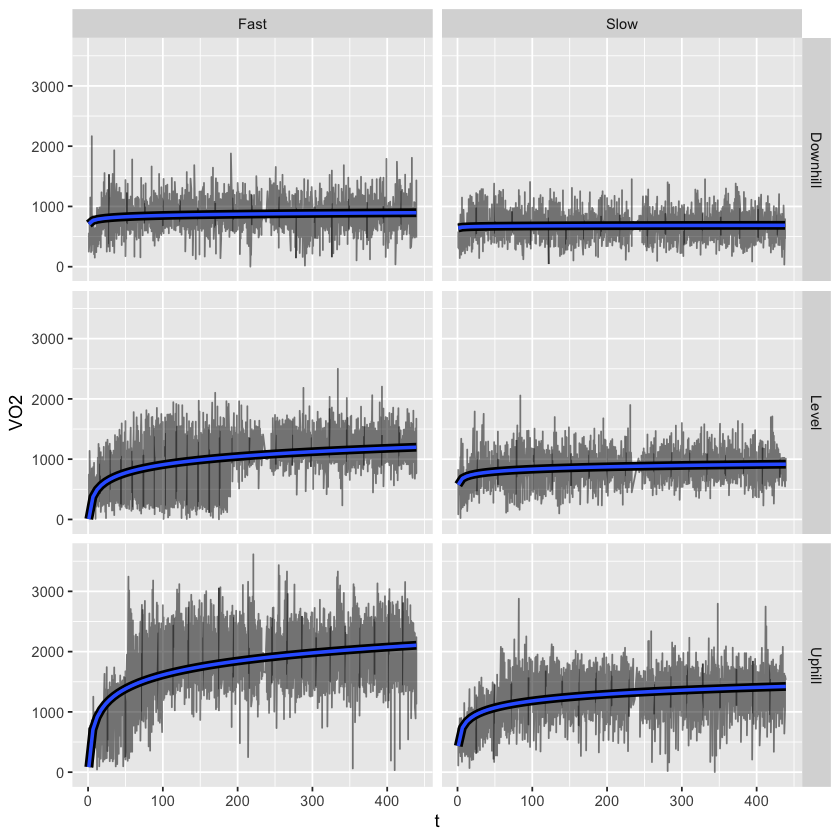

In [139]:
# Compare linear vs logarithmic models
anova(fit.lme, fit.lme.log)

# Visualize log relationship
ggplot(data.all, aes(x = t, y = VO2)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm', formula = "y~log(x)", color = "black", se = F, size = 2.5) +
  geom_smooth(method = 'lm', formula = "y~log(x)") +
  facet_grid(Level ~ Speed)

In [142]:
# What if instead of a log we model it as a 2nd degree polynomial
fit.lme.poly2 <- lme(VO2 ~ poly(t, 2, raw = TRUE)*Speed +
                  poly(t, 2, raw = TRUE)*Level + Age + Gender,
            random = ~1|Sub,
            method = "ML",
            data.all)

Anova(fit.lme.poly2)
vif(fit.lme.poly2)
summary(fit.lme.poly2)
AIC(fit.lme.poly2)
emtrends(fit.lme.poly2, pairwise ~ Level, var = "t")

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
"poly(t, 2, raw = TRUE)",3114.71452,2,0.000000e+00
Speed,3547.28102,1,0.000000e+00
Level,18203.54575,2,0.000000e+00
Age,1.85093,1,1.736753e-01
Gender,1.07322,1,3.002194e-01
"poly(t, 2, raw = TRUE):Speed",643.69387,2,1.673600e-140
"poly(t, 2, raw = TRUE):Level",1480.68557,4,2.204126e-319


,GVIF,Df,GVIF^(1/(2*Df))
"poly(t, 2, raw = TRUE)",18.307246,2,2.068501
Speed,9.141569,1,3.023503
Level,82.588944,2,3.014605
Age,1.304078,1,1.141962
Gender,1.304062,1,1.141955
"poly(t, 2, raw = TRUE):Speed",18.953302,2,2.086514
"poly(t, 2, raw = TRUE):Level",333.075849,4,2.066893


Linear mixed-effects model fit by maximum likelihood
  Data: data.all 
       AIC      BIC    logLik
  207730.9 207852.4 -103849.5

Random effects:
 Formula: ~1 | Sub
        (Intercept) Residual
StdDev:    153.9359 288.5273

Fixed effects:  VO2 ~ poly(t, 2, raw = TRUE) * Speed + poly(t, 2, raw = TRUE) *      Level + Age + Gender 
                                        Value Std.Error    DF    t-value
(Intercept)                          338.1266 231.20204 14631   1.462472
poly(t, 2, raw = TRUE)1                1.7887   0.15917 14631  11.238002
poly(t, 2, raw = TRUE)2               -0.0031   0.00035 14631  -8.734028
SpeedSlow                             28.3196  14.47749 14631   1.956112
LevelLevel                          -142.0628  17.55675 14631  -8.091634
LevelUphill                          123.2148  18.24374 14631   6.753814
Age                                   13.9320  10.24530    10   1.359839
GenderM                              101.4784  98.00240    10   1.035468
poly(t, 2,

[1] 207730.9

,(Intercept),"poly(t, 2, raw = TRUE)1","poly(t, 2, raw = TRUE)2",SpeedSlow,LevelLevel,LevelUphill,Age,GenderM,"poly(t, 2, raw = TRUE)1:SpeedSlow","poly(t, 2, raw = TRUE)2:SpeedSlow","poly(t, 2, raw = TRUE)1:LevelLevel","poly(t, 2, raw = TRUE)2:LevelLevel","poly(t, 2, raw = TRUE)1:LevelUphill","poly(t, 2, raw = TRUE)2:LevelUphill"
(Intercept),5.345438e+04,-2.071442e+00,3.940746e-03,-1.044434e+02,-1.834069e+02,-1.694514e+02,-2.274139e+03,6.539687e+03,9.688750e-01,-1.831980e-03,1.695230e+00,-3.231406e-03,1.605839e+00,-3.062579e-03
"poly(t, 2, raw = TRUE)1",-2.071442e+00,2.533495e-02,-5.399227e-05,9.851047e-01,1.696132e+00,1.599165e+00,-4.569248e-04,5.904069e-04,-1.193484e-02,2.536596e-05,-2.041483e-02,4.335954e-05,-1.956598e-02,4.181631e-05
"poly(t, 2, raw = TRUE)2",3.940746e-03,-5.399227e-05,1.222630e-07,-1.877034e-03,-3.224384e-03,-3.056977e-03,1.453560e-06,-5.436786e-06,2.536663e-05,-5.726751e-08,4.336167e-05,-9.780818e-08,4.181499e-05,-9.498771e-08
SpeedSlow,-1.044434e+02,9.851047e-01,-1.877034e-03,2.095978e+02,2.780726e+01,3.216236e+00,-9.099879e-02,-3.520180e-01,-1.941772e+00,3.711140e-03,-2.223798e-01,3.919762e-04,-3.285452e-02,6.616752e-05
LevelLevel,-1.834069e+02,1.696132e+00,-3.224384e-03,2.780726e+01,3.082395e+02,1.716842e+02,-7.039525e-02,-6.655203e-01,-2.229146e-01,3.948610e-04,-2.882849e+00,5.534169e-03,-1.585486e+00,3.028271e-03
LevelUphill,-1.694514e+02,1.599165e+00,-3.056977e-03,3.216236e+00,1.716842e+02,3.328341e+02,-1.362560e-01,-1.980611e-01,-3.313123e-02,6.746343e-05,-1.585998e+00,3.028520e-03,-3.054354e+00,5.813080e-03
Age,-2.274139e+03,-4.569248e-04,1.453560e-06,-9.099879e-02,-7.039525e-02,-1.362560e-01,1.049662e+02,-4.848289e+02,6.279178e-04,-1.871423e-06,-1.726411e-06,3.674467e-07,-1.812822e-04,-7.214507e-08
GenderM,6.539687e+03,5.904069e-04,-5.436786e-06,-3.520180e-01,-6.655203e-01,-1.980611e-01,-4.848289e+02,9.604470e+03,2.399582e-03,-2.101507e-06,8.141293e-04,2.184319e-06,-5.677019e-03,1.681205e-05
"poly(t, 2, raw = TRUE)1:SpeedSlow",9.688750e-01,-1.193484e-02,2.536663e-05,-1.941772e+00,-2.229146e-01,-3.313123e-02,6.279178e-04,2.399582e-03,2.374878e-02,-5.073330e-05,2.132667e-03,-4.069857e-06,4.658985e-04,-1.036350e-06
"poly(t, 2, raw = TRUE)2:SpeedSlow",-1.831980e-03,2.536596e-05,-5.726751e-08,3.711140e-03,3.948610e-04,6.746343e-05,-1.871423e-06,-2.101507e-06,-5.073330e-05,1.152668e-07,-4.074906e-06,7.966207e-09,-1.035701e-06,2.420910e-09


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fit.lme,"lme.formula(fixed = VO2 ~ t * Speed + t * Level + Age + Gender, data = data.all, random = ~1 | Sub, method = ""ML"")",1,12,209435.1,209526.2,-104705.6,,NA,NA
fit.lme.poly2,"lme.formula(fixed = VO2 ~ poly(t, 2, raw = TRUE) * Speed + poly(t, 2, raw = TRUE) * Level + Age + Gender, data = data.all, random = ~1 | Sub, method = ""ML"")",2,16,207730.9,207852.4,-103849.5,1 vs 2,1712.193969,0.0000000
fit.lme.log,"lme.formula(fixed = VO2 ~ log(t) * Speed + log(t) * Level + Age + Gender, data = data.all, random = ~1 | Sub, method = ""ML"")",3,12,207725.4,207816.5,-103850.7,2 vs 3,2.472314,0.6496002


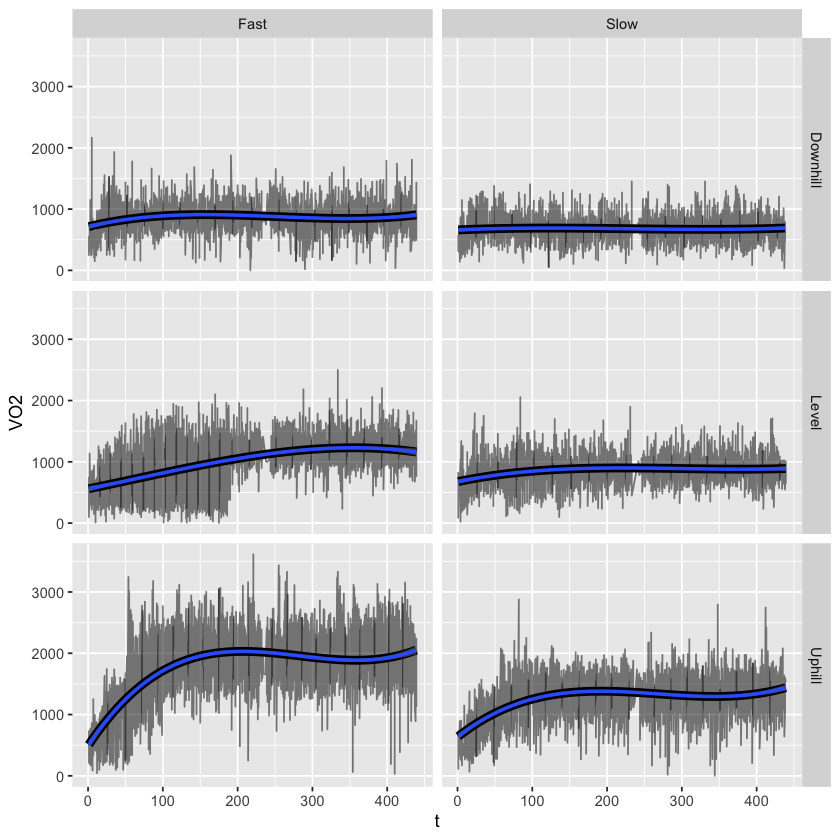

In [143]:
# In this case a log model is just as good as a poly model and a little simpler
anova(fit.lme, fit.lme.poly2, fit.lme.log)

# However, there may exist a model that is more complex and a better fit.
ggplot(data.all, aes(x = t, y = VO2)) +
  geom_line(alpha = .5) +
  geom_smooth(method = 'lm', formula = "y~poly(x,3)", color = "black", se = F, size = 2.5) +
  geom_smooth(method = 'lm', formula = "y~poly(x,3)") +
  facet_grid(Level ~ Speed)

### At this point we would move to a non-linear mixed effects model for more complex relationships.

# The End